In [1]:
import pandas as pd
import numpy as np

# Using the yfinance library to download historical stock data for NVIDIA (NVDA)
# From January 1, 2015, to the present day.
#!pip install yfinance
import yfinance as yf
nvda = yf.download('NVDA', start='2015-01-01')  
print(nvda.tail())

# Checking for missing values in the dataset
print(nvda.isna().sum().sum())
# As there are no missing values, we can proceed with the analysis.

# Importing the technical analysis library
#!pip install ta 
import ta

/var/folders/py/pk80p4l95gjbynd00fzl_3d00000gn/T/ipykernel_34898/1790041993.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvda = yf.download('NVDA', start='2015-01-01')
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA
Date                                                                 
2025-08-25  179.809998  181.910004  176.570007  178.350006  163012800
2025-08-26  181.770004  182.389999  178.809998  180.059998  168688200
2025-08-27  181.600006  182.490005  179.100006  181.979996  235518900
2025-08-28  180.169998  184.470001  176.410004  180.820007  281787800
2025-08-29  174.179993  178.149994  173.149994  178.110001  242726800
0


## Adding basic features to the dataset to use in our ML models

In [2]:
# Feature Engineering

# Up/Down Movement
nvda['Target'] = (nvda['Close'].shift(-1) > nvda['Close']).astype(int)

nvda['Return'] = nvda['Close'].pct_change()

# Rolling Statistics
nvda['MA5'] = nvda['Close'].rolling(window=5).mean()
nvda['MA10'] = nvda['Close'].rolling(window=10).mean()
nvda['MA20'] = nvda['Close'].rolling(window=20).mean()

# Volatility
nvda['Volatility5'] = nvda['Return'].rolling(window=5).std()
nvda['Volatility10'] = nvda['Return'].rolling(window=10).std()

# Momentum
nvda['Momentum5'] = nvda['Close'] - nvda['Close'].shift(5)
nvda['Momentum10'] = nvda['Close'] - nvda['Close'].shift(10)

# Price Ratios
nvda['Close/Open'] = nvda['Close'] / nvda['Open']
nvda['High/Low'] = nvda['High'] / nvda['Low']

# Volume Change
nvda['Volume_Change'] = nvda['Volume'].pct_change()

# Drop rows with NaNs caused by rolling calculations
nvda.dropna(inplace=True)

# Check the final dataset with features
print(nvda.tail())

# Displaying the columns to verify the features added
print(nvda.columns.tolist())



Price            Close        High         Low        Open     Volume Target  \
Ticker            NVDA        NVDA        NVDA        NVDA       NVDA          
Date                                                                           
2025-08-25  179.809998  181.910004  176.570007  178.350006  163012800      1   
2025-08-26  181.770004  182.389999  178.809998  180.059998  168688200      0   
2025-08-27  181.600006  182.490005  179.100006  181.979996  235518900      0   
2025-08-28  180.169998  184.470001  176.410004  180.820007  281787800      0   
2025-08-29  174.179993  178.149994  173.149994  178.110001  242726800      0   

Price         Return         MA5        MA10        MA20 Volatility5  \
Ticker                                                                 
Date                                                                   
2025-08-25  0.010225  176.763998  179.304999  179.131499    0.020045   
2025-08-26  0.010900  177.989999  179.165999  179.444499    0.008484   

## Model Choice: Random Forest

I’m starting with Random Forest because it’s a solid, easy-to-use model that works well with different types of features and can capture complex patterns. It’s less likely to overfit compared to single decision trees and doesn’t need a lot of tuning upfront. Plus, it gives insight into which features matter most, which is helpful when exploring financial data.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features and target
# I have removed Date, raw price columns from Features

# Flatten MultiIndex columns
nvda.columns = ['_'.join(filter(None, col)).strip() for col in nvda.columns.values]

X = nvda[
    ['Return', 'MA5', 'MA10', 'MA20',
     'Volatility5', 'Volatility10',
     'Momentum5', 'Momentum10',
     'Close/Open', 'High/Low',
     'Volume_NVDA']
]
y = nvda['Target']

# Train/test split (no shuffle to keep time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize Random Forest with baseline parameters
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'  # helps if classes are imbalanced
)

# Train model
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

# Do 5-fold time-series-split cross-validation to get better accuracy scores, Test for over/underfitting
from sklearn.model_selection import TimeSeriesSplit, cross_validate

# Define model
rf_1 = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    class_weight='balanced'         
)

# Perform cross-validation
cv_results = cross_validate(rf_1, X, y, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', return_train_score=True)

print("Train scores:", cv_results['train_score'])
print("Validation scores:", cv_results['test_score'])

print("Mean train accuracy:", np.mean(cv_results['train_score']))
print("Mean validation accuracy:", np.mean(cv_results['test_score']))


              precision    recall  f1-score   support

           0       0.44      0.70      0.54       239
           1       0.53      0.28      0.36       294

    accuracy                           0.47       533
   macro avg       0.48      0.49      0.45       533
weighted avg       0.49      0.47      0.44       533

Train scores: [0.83668904 0.80898876 0.75168792 0.74155405 0.72239748]
Validation scores: [0.45823928 0.50564334 0.4785553  0.48306998 0.4537246 ]
Mean train accuracy: 0.7722634508903014
Mean validation accuracy: 0.4758465011286682


As you can see here we have an overfitting problem. I am going to adjust the model to try and reduce the overfitting

In [4]:
rf_2 = RandomForestClassifier(
    n_estimators=100,          # Keep enough trees for stability
    max_depth=3,               # Shallower trees to reduce complexity
    min_samples_split=20,      # Require larger node size to split
    min_samples_leaf=10,       # Minimum leaf size to prevent small noisy leaves
    max_features='sqrt',       # Use sqrt of features at each split (common practice)
    random_state=42,
    class_weight='balanced'    # Handle class imbalance if any
)

cv_results_2 = cross_validate(rf_2, X, y, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', return_train_score=True)

print("Train scores:", cv_results_2['train_score'])
print("Validation scores:", cv_results_2['test_score'])

print("Mean train accuracy:", np.mean(cv_results_2['train_score']))
print("Mean validation accuracy:", np.mean(cv_results_2['test_score']))

Train scores: [0.71364653 0.6505618  0.63990998 0.625      0.62190176]
Validation scores: [0.45823928 0.51693002 0.45598194 0.46952596 0.44920993]
Mean train accuracy: 0.6502040130468213
Mean validation accuracy: 0.46997742663656883


We have reduced overfitting slightly, however validation accuracy remains low at ~52%. Let's now focus on improving this. I will begin by adding a wide range of potentially relevant features to the model, and then carry out feature importance analysis to aggressively reduce to only the most impactful ones.

In [5]:

# Alias for convenience with suffixed columns
close = nvda['Close_NVDA']
high = nvda['High_NVDA']
low = nvda['Low_NVDA']
open_ = nvda['Open_NVDA']
volume = nvda['Volume_NVDA']

# Lagged Returns - recent return history to capture momentum
nvda['Return_1'] = nvda['Return'].shift(1)
nvda['Return_2'] = nvda['Return'].shift(2)
nvda['Return_3'] = nvda['Return'].shift(3)

# Daily Range - intraday volatility measure
nvda['Daily_Range'] = high - low

# Rolling Max/Min - price extremes over past 10 days
nvda['Max10'] = close.rolling(window=10).max()
nvda['Min10'] = close.rolling(window=10).min()
nvda['Close_to_High10'] = close / nvda['Max10']
nvda['Close_to_Low10'] = close / nvda['Min10']

# Price Deviation from Moving Averages - mean reversion signals
nvda['Dev_MA5'] = close - nvda['MA5']
nvda['Dev_MA10'] = close - nvda['MA10']

# Rolling Average Volume and Volume Spike ratio
nvda['AvgVol5'] = volume.rolling(window=5).mean()
nvda['Vol/AvgVol5'] = volume / nvda['AvgVol5']  # large values could indicate unusual activity

# RSI (Relative Strength Index) - momentum and reversal indicator
delta = close.diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
nvda['RSI'] = 100 - (100 / (1 + rs))

# MACD and Signal Line - trend following and momentum
ema12 = close.ewm(span=12, adjust=False).mean()
ema26 = close.ewm(span=26, adjust=False).mean()
nvda['MACD'] = ema12 - ema26
nvda['Signal_Line'] = nvda['MACD'].ewm(span=9, adjust=False).mean()

# Candle Body and Wick Ratios - indicate market sentiment within day
nvda['Body'] = abs(close - open_)
nvda['Upper_Wick'] = high - np.maximum(close, open_)
nvda['Lower_Wick'] = np.minimum(close, open_) - low
nvda['Body/Range'] = nvda['Body'] / nvda['Daily_Range']

# Volume Price Trend (VPT) - cumulative volume weighted price change, volume + price action
nvda['VPT'] = (volume * close.pct_change()).cumsum()

# Bollinger Bands - volatility bands around MA20
nvda['MA20'] = close.rolling(window=20).mean()  # just in case not added yet
nvda['BB_upper'] = nvda['MA20'] + 2 * close.rolling(window=20).std()
nvda['BB_lower'] = nvda['MA20'] - 2 * close.rolling(window=20).std()
nvda['BB_width'] = nvda['BB_upper'] - nvda['BB_lower']  # width as volatility measure

# Stochastic Oscillator (%K and %D) - momentum oscillator
lowest_low_14 = low.rolling(window=14).min()
highest_high_14 = high.rolling(window=14).max()
nvda['Stoch_%K'] = 100 * (close - lowest_low_14) / (highest_high_14 - lowest_low_14)
nvda['Stoch_%D'] = nvda['Stoch_%K'].rolling(window=3).mean()

# ATR (Average True Range) - volatility measure based on high-low and gaps
high_low = high - low
high_close_prev = abs(high - close.shift(1))
low_close_prev = abs(low - close.shift(1))
true_range = pd.Series(np.maximum.reduce([high_low, high_close_prev, low_close_prev]), index=nvda.index)
nvda['ATR'] = true_range.rolling(window=14).mean()

# Momentum Indicators - price change over different lags (some you have but adding more)
nvda['Momentum_3'] = close - close.shift(3)
nvda['Momentum_7'] = close - close.shift(7)
nvda['Momentum_14'] = close - close.shift(14)

# Volume Moving Averages - different windows to capture volume trends
nvda['AvgVol10'] = volume.rolling(window=10).mean()
nvda['AvgVol20'] = volume.rolling(window=20).mean()

# Volume Oscillator - difference between short and long volume MAs
nvda['Vol_Oscillator'] = nvda['AvgVol5'] - nvda['AvgVol20']

# Drop NaNs caused by rolling and shifting
nvda.dropna(inplace=True)


# Carrying out RF with new features
X_3 = nvda.drop(columns=['Target', 'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA'])
y_3 = nvda['Target']

rf_3 = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

cv_results_3 = cross_validate(rf_3, X_3, y_3, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', return_train_score=True)

print("Train scores:", cv_results_3['train_score'])
print("Validation scores:", cv_results_3['test_score'])

print("Mean train accuracy:", np.mean(cv_results_3['train_score']))
print("Mean validation accuracy:", np.mean(cv_results_3['test_score']))

Train scores: [0.9006772  0.84711212 0.80801209 0.77765173 0.77712211]
Validation scores: [0.52272727 0.47727273 0.49090909 0.48181818 0.46136364]
Mean train accuracy: 0.8221150497268146
Mean validation accuracy: 0.4868181818181818


Time for feature importance analysis. We will start by looking for high magnitude to find redundant features

In [6]:
import numpy as np
import pandas as pd

# Calculate correlation matrix
corr_matrix = nvda.drop(columns=['Target','Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA']).corr().abs()

# Select upper triangle of correlation matrix without diagonal
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Set threshold for "high" correlation
threshold = 0.9

# Find pairs with correlation above threshold
high_corr_pairs = [(col, row, upper.loc[row, col]) 
                   for col in upper.columns 
                   for row in upper.index 
                   if (upper.loc[row, col] > threshold)]

# Convert to DataFrame for nicer display
high_corr_df = pd.DataFrame(high_corr_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

#print(high_corr_df)

### Due to the large number of features, we will summarize the most common features in high correlation pairs

from collections import Counter

# Flatten list of feature names from pairs (both Feature 1 and Feature 2)
features_in_pairs = [feat for pair in high_corr_pairs for feat in pair[:2]]

# Count appearances
feature_counts = Counter(features_in_pairs)

# Convert to DataFrame for nicer display
feature_counts_df = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Count']).sort_values(by='Count', ascending=False)

print(feature_counts_df)

        Feature  Count
9      BB_upper      8
14          ATR      8
1           MA5      7
10     BB_lower      7
0          MA10      7
4         Min10      7
3         Max10      7
2          MA20      7
5      Dev_MA10      2
11     BB_width      2
6     Momentum5      1
7   Signal_Line      1
8          MACD      1
12     Stoch_%D      1
13     Stoch_%K      1
15   Momentum_3      1
16      Dev_MA5      1
17   Momentum_7      1


As expected there are lots of correlations due to lots of different features calculated using each other. I will drop a few features with lots of correlation and see if validation accuracy improves with less noise and fewer overlapping features

In [7]:
# Based on the correlation analysis, we will drop some features to reduce redundancy

X_4 = nvda.drop(columns=['Target', 'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA',    
                         'MA5',          # Keep MA10 instead (middle ground smoothing)
                         'Max10',        # Drop price extremes (optional, keep Min10 if you want)
                         'BB_upper',     # Bollinger upper band overlaps with MA and price
                         'BB_lower'      # Bollinger lower band overlaps with MA and price
                        ])
y_4 = nvda['Target']

rf_4 = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

cv_results_4 = cross_validate(rf_4, X_4, y_4, cv=TimeSeriesSplit(n_splits=5), scoring='accuracy', return_train_score=True)

print("Train scores:", cv_results_4['train_score'])
print("Validation scores:", cv_results_4['test_score'])

print("Mean train accuracy:", np.mean(cv_results_4['train_score']))
print("Mean validation accuracy:", np.mean(cv_results_4['test_score']))

Train scores: [0.90519187 0.82899207 0.80725624 0.79863868 0.77303677]
Validation scores: [0.52727273 0.50227273 0.48181818 0.48636364 0.47272727]
Mean train accuracy: 0.8226231268003692
Mean validation accuracy: 0.494090909090909


That did not do much: time for some feature importance analysis. We’ll start with Permutation Importance (quick and easy), then dive into SHAP for deeper interpretability. Finally, we’ll compare both and drop or tweak any weak features

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Fit rf_4 on the full data first
rf_4.fit(X_4, y_4)

# Calculate Permutation Importance on the training data
result = permutation_importance(rf_4, X_4, y_4, n_repeats=10, random_state=42, scoring='accuracy')

# Extract importance and feature names
importances = result.importances_mean
std = result.importances_std
features = X_4.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Print feature ranking
print("Feature ranking by permutation importance:")
for i in indices:
    print(f"{features[i]}: {importances[i]:.4f} +/- {std[i]:.4f}")



Feature ranking by permutation importance:
Vol_Oscillator: 0.0274 +/- 0.0031
Return_2: 0.0252 +/- 0.0031
Upper_Wick: 0.0195 +/- 0.0032
Return_1: 0.0194 +/- 0.0044
Body/Range: 0.0182 +/- 0.0015
Return: 0.0174 +/- 0.0024
Close/Open: 0.0171 +/- 0.0025
RSI: 0.0158 +/- 0.0037
Stoch_%D: 0.0154 +/- 0.0027
AvgVol20: 0.0149 +/- 0.0045
Volatility10: 0.0149 +/- 0.0026
Vol/AvgVol5: 0.0145 +/- 0.0024
Close_to_Low10: 0.0142 +/- 0.0039
Lower_Wick: 0.0142 +/- 0.0042
Return_3: 0.0123 +/- 0.0029
Dev_MA10: 0.0122 +/- 0.0023
Signal_Line: 0.0122 +/- 0.0023
Momentum_7: 0.0117 +/- 0.0036
Dev_MA5: 0.0116 +/- 0.0021
Volume_Change: 0.0108 +/- 0.0024
Body: 0.0106 +/- 0.0023
BB_width: 0.0104 +/- 0.0033
Volatility5: 0.0099 +/- 0.0037
ATR: 0.0099 +/- 0.0016
Momentum_14: 0.0096 +/- 0.0039
Daily_Range: 0.0096 +/- 0.0031
Close_to_High10: 0.0095 +/- 0.0029
MACD: 0.0092 +/- 0.0012
AvgVol5: 0.0081 +/- 0.0020
Momentum10: 0.0073 +/- 0.0019
AvgVol10: 0.0072 +/- 0.0022
Momentum_3: 0.0072 +/- 0.0020
MA10: 0.0069 +/- 0.0025
Mi

In [16]:
#!pip install shap
import shap
from sklearn.model_selection import train_test_split

# 1. Create SHAP Explainer
# For tree-based models, use TreeExplainer for exact SHAP values
explainer = shap.TreeExplainer(rf_4)

# 2. Calculate SHAP values
# This may take some time for large datasets
shap_values = explainer.shap_values(X_4)

# For binary classification, shap_values might be a list
# Take values for positive class (usually index 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# 3. Get expected value (base value)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]

# 4. Verify SHAP values
print("=== SHAP Values Verification ===")

# Check shape
print(f"SHAP values shape: {shap_values.shape}")
print(f"X_4 shape: {X_4.shape}")
print(f"Shape match: {shap_values.shape == X_4.shape}")


=== SHAP Values Verification ===
SHAP values shape: (2643, 39, 2)
X_4 shape: (2643, 39)
Shape match: False


Combining permutation importance and SHAP to remove unimportant features

In [17]:
# 1. Get feature names
feature_names = X_4.columns.tolist() if hasattr(X_4, 'columns') else [f'Feature_{i}' for i in range(X_4.shape[1])]
print(f"Length of feature_names: {len(feature_names)}")

# 2. Calculate SHAP importance per feature
# Reshape if needed (handle flattened array)
if len(shap_values.shape) == 1 and len(shap_values) == X_4.shape[0] * X_4.shape[1]:
    shap_values = shap_values.reshape(X_4.shape[0], X_4.shape[1])

shap_importance = np.mean(np.abs(shap_values), axis=0)
print(f"After calculation - shap_importance length: {len(shap_importance)}")


# 3. Get permutation importance
perm_importance = result.importances_mean

# 4. Set thresholds (adjust these based on your needs)
perm_threshold = np.percentile(perm_importance, 25)  # Bottom 25%
shap_threshold = np.percentile(shap_importance, 25)

# 5. Find unimportant features
unimportant_perm = set([feature_names[i] for i, imp in enumerate(perm_importance) if imp < perm_threshold])
shap_importance = np.array(shap_importance).flatten()  # Ensure it's a 1D numpy array
unimportant_shap = set([name for name, imp in zip(feature_names, shap_importance) if imp < shap_threshold])

# 6. Features to remove (unimportant in BOTH methods)
features_to_remove = unimportant_perm.intersection(unimportant_shap)

print("=== FEATURE REMOVAL SUMMARY ===")
print(f"\nThresholds used:")
print(f"  Permutation importance: < {perm_threshold}")
print(f"  SHAP importance: < {shap_threshold:.6f}")

print(f"\nFeatures below SHAP threshold ({len(unimportant_shap)}):")
for feat in sorted(unimportant_shap):
    idx = feature_names.index(feat)
    print(f"  {feat}: {shap_importance[idx]:.6f}")

print(f"\nFeatures below permutation threshold ({len(unimportant_perm)}):")
for feat in sorted(unimportant_perm):
    idx = feature_names.index(feat)
    print(f"  {feat}: {perm_importance[idx]:.4f}")

print(f"\n=== FEATURES TO REMOVE (unimportant in BOTH) ===")
print(f"Total: {len(features_to_remove)} features")
for feat in sorted(features_to_remove):
    idx = feature_names.index(feat)
    print(f"  {feat}: Perm={perm_importance[idx]:.4f}, SHAP={shap_importance[idx]:.6f}")


Length of feature_names: 39
After calculation - shap_importance length: 39
=== FEATURE REMOVAL SUMMARY ===

Thresholds used:
  Permutation importance: < 0.007718501702610697
  SHAP importance: < 0.001453

Features below SHAP threshold (9):
  Close_to_Low10: 0.001263
  Daily_Range: 0.001095
  Dev_MA5: 0.001263
  MA20: 0.000973
  Return_1: 0.000990
  Return_2: 0.000990
  Return_3: 0.001095
  Vol_Oscillator: 0.000995
  Volatility5: 0.000973

Features below permutation threshold (10):
  AvgVol10: 0.0072
  High/Low: 0.0065
  MA10: 0.0069
  MA20: 0.0041
  Min10: 0.0067
  Momentum10: 0.0073
  Momentum5: 0.0059
  Momentum_3: 0.0072
  Stoch_%K: 0.0034
  VPT: 0.0042

=== FEATURES TO REMOVE (unimportant in BOTH) ===
Total: 1 features
  MA20: Perm=0.0041, SHAP=0.000973


Permutation importance and SHAP values seem to be very disconnected from each other, making it hard to use both to find values to remove. 

Hence I have decided to try a forward selection instead.

Starting feature selection with 39 features...
This may take a few minutes...



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   59.2s finished

[2025-08-30 14:53:25] Features: 1/39 -- score: 0.5444444444444444[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:   25.7s finished

[2025-08-30 14:53:51] Features: 2/39 -- score: 0.5494949494949495[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:   31.1s finished

[2025-08-30 14:54:22] Features: 3/39 -- score: 0.551010101010101[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   21.9s finished

[2025-08-30 14:54:44] Features: 4/39 -- score: 0.544949494949495[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   20.2s finished

[2


=== FORWARD SELECTION RESULTS ===
Optimal number of features: 10
Best CV score: 0.5540

Selected features:
  - Volatility5
  - Volatility10
  - Close/Open
  - Return_2
  - Close_to_High10
  - Close_to_Low10
  - Upper_Wick
  - Stoch_%D
  - AvgVol20
  - Vol_Oscillator


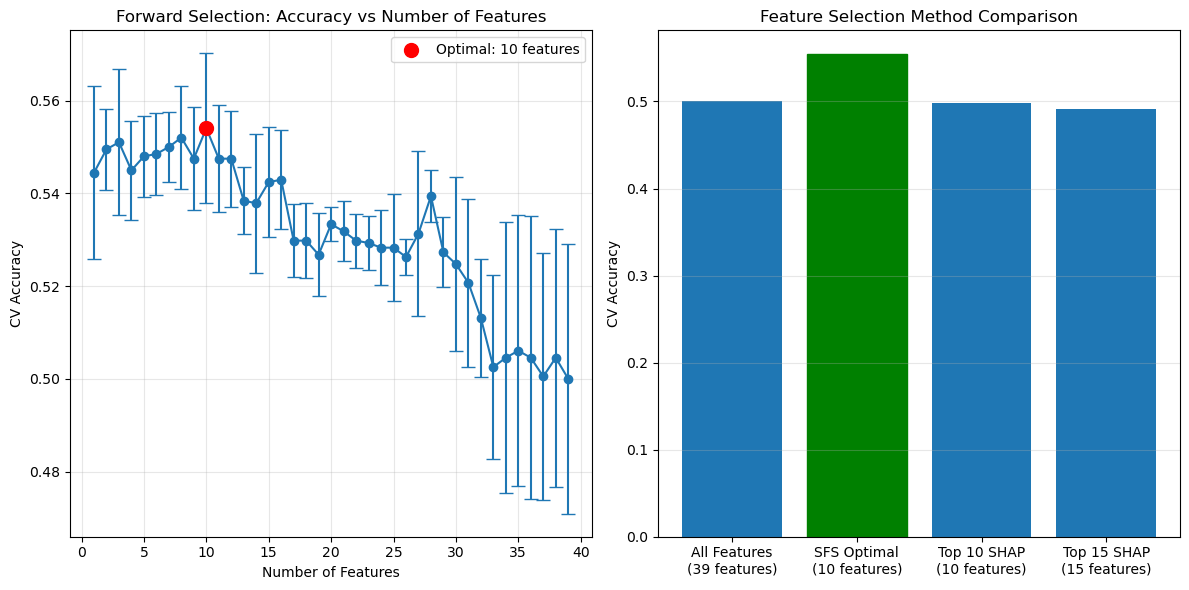


=== FINAL DATASET ===
X_optimal shape: (2643, 10)
Features: ['Volatility5', 'Volatility10', 'Close/Open', 'Return_2', 'Close_to_High10', 'Close_to_Low10', 'Upper_Wick', 'Stoch_%D', 'AvgVol20', 'Vol_Oscillator']

=== FEATURES NOT SELECTED (29) ===
  - ATR
  - AvgVol10
  - AvgVol5
  - BB_width
  - Body
  - Body/Range
  - Daily_Range
  - Dev_MA10
  - Dev_MA5
  - High/Low
  - Lower_Wick
  - MA10
  - MA20
  - MACD
  - Min10
  - Momentum10
  - Momentum5
  - Momentum_14
  - Momentum_3
  - Momentum_7
  - RSI
  - Return
  - Return_1
  - Return_3
  - Signal_Line
  - Stoch_%K
  - VPT
  - Vol/AvgVol5
  - Volume_Change

=== TRYING BACKWARD ELIMINATION (Optional) ===
This removes features starting from all features...

=== SAVED RESULTS ===
Selected features saved to 'sfs_selected_features.csv'


In [18]:
!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Prepare your data
# Remove base columns that should never be included
base_drops = ['Target', 'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 
              'Volume_NVDA', 'MA5', 'Max10', 'BB_upper', 'BB_lower']

X_for_selection = nvda.drop(columns=base_drops)
y_for_selection = nvda['Target']

# Get feature names for interpretation
feature_names_selection = X_for_selection.columns.tolist()

print(f"Starting feature selection with {len(feature_names_selection)} features...")
print(f"This may take a few minutes...\n")

# 1. Forward Selection - Start with 0, add best features one by one
sfs_forward = SFS(
    RandomForestClassifier(
        n_estimators=rf_4.n_estimators,
        max_depth=rf_4.max_depth,
        random_state=rf_4.random_state,
        n_jobs=1  # Set to 1 within SFS to avoid conflicts
    ),
    k_features='best',  # Automatically find optimal number
    forward=True,
    floating=False,  # Set True for more thorough search (slower)
    scoring='accuracy',
    cv=TimeSeriesSplit(n_splits=3),  # Time series validation
    n_jobs=-1,  # Parallelize across CV folds
    verbose=2  # Show progress
)

# Fit the selector
sfs_forward = sfs_forward.fit(X_for_selection, y_for_selection)

# 2. Display results
print("\n=== FORWARD SELECTION RESULTS ===")
print(f"Optimal number of features: {len(sfs_forward.k_feature_names_)}")
print(f"Best CV score: {sfs_forward.k_score_:.4f}")
print("\nSelected features:")
for feat in sfs_forward.k_feature_names_:
    print(f"  - {feat}")

# 3. Plot the selection process
# Get the results for each number of features
metric_dict = sfs_forward.get_metric_dict()

# Extract data for plotting
k_features = []
avg_scores = []
std_scores = []

for k in sorted(metric_dict.keys()):
    k_features.append(k)
    avg_scores.append(metric_dict[k]['avg_score'])
    std_scores.append(metric_dict[k]['std_dev'])

# Create performance plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.errorbar(k_features, avg_scores, yerr=std_scores, marker='o', capsize=5)
plt.xlabel('Number of Features')
plt.ylabel('CV Accuracy')
plt.title('Forward Selection: Accuracy vs Number of Features')
plt.grid(True, alpha=0.3)

# Highlight the optimal point
optimal_k = len(sfs_forward.k_feature_names_)
optimal_score = sfs_forward.k_score_
plt.scatter(optimal_k, optimal_score, color='red', s=100, zorder=5, 
           label=f'Optimal: {optimal_k} features')
plt.legend()

# 4. Compare with other methods
plt.subplot(1, 2, 2)

# Calculate scores for different feature sets
methods = {
    'All Features': list(feature_names_selection),
    'SFS Optimal': list(sfs_forward.k_feature_names_),
    'Top 10 SHAP': [feat for feat, _ in sorted(zip(feature_names, shap_importance), 
                                               key=lambda x: x[1], reverse=True)[:10]],
    'Top 15 SHAP': [feat for feat, _ in sorted(zip(feature_names, shap_importance), 
                                               key=lambda x: x[1], reverse=True)[:15]]
}

# Remove features not in X_for_selection from SHAP selections
methods['Top 10 SHAP'] = [f for f in methods['Top 10 SHAP'] if f in feature_names_selection]
methods['Top 15 SHAP'] = [f for f in methods['Top 15 SHAP'] if f in feature_names_selection]

method_scores = []
method_names = []

for method_name, features in methods.items():
    X_method = X_for_selection[features]
    scores = []
    
    tscv = TimeSeriesSplit(n_splits=3)
    for train_idx, test_idx in tscv.split(X_method):
        X_train, X_test = X_method.iloc[train_idx], X_method.iloc[test_idx]
        y_train, y_test = y_for_selection.iloc[train_idx], y_for_selection.iloc[test_idx]
        
        rf_temp = RandomForestClassifier(
            n_estimators=rf_4.n_estimators,
            max_depth=rf_4.max_depth,
            random_state=rf_4.random_state
        )
        rf_temp.fit(X_train, y_train)
        scores.append(rf_temp.score(X_test, y_test))
    
    method_scores.append(np.mean(scores))
    method_names.append(f"{method_name}\n({len(features)} features)")

# Plot comparison
bars = plt.bar(range(len(method_names)), method_scores)
plt.xticks(range(len(method_names)), method_names)
plt.ylabel('CV Accuracy')
plt.title('Feature Selection Method Comparison')
plt.grid(axis='y', alpha=0.3)

# Highlight best method
best_idx = np.argmax(method_scores)
bars[best_idx].set_color('green')

plt.tight_layout()
plt.show()

# 5. Create optimal dataset
X_optimal = X_for_selection[list(sfs_forward.k_feature_names_)]
print(f"\n=== FINAL DATASET ===")
print(f"X_optimal shape: {X_optimal.shape}")
print(f"Features: {list(X_optimal.columns)}")

# 6. Show features that were NOT selected
not_selected = set(feature_names_selection) - set(sfs_forward.k_feature_names_)
print(f"\n=== FEATURES NOT SELECTED ({len(not_selected)}) ===")
for feat in sorted(not_selected):
    print(f"  - {feat}")

# 7. Optional: Try backward elimination for comparison
print("\n=== TRYING BACKWARD ELIMINATION (Optional) ===")
print("This removes features starting from all features...")

sfs_backward = SFS(
    RandomForestClassifier(
        n_estimators=rf_4.n_estimators,
        max_depth=rf_4.max_depth,
        random_state=rf_4.random_state,
        n_jobs=1
    ),
    k_features=10,  # Specify target number
    forward=False,  # Backward elimination
    floating=False,
    scoring='accuracy',
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1,
    verbose=1
)

# Uncomment to run backward elimination (slower)
# sfs_backward = sfs_backward.fit(X_for_selection, y_for_selection)
# print(f"Backward elimination score: {sfs_backward.k_score_:.4f}")
# print(f"Selected features: {sfs_backward.k_feature_names_}")

# Save the selected features for future use
selected_features_df = pd.DataFrame({
    'feature': list(sfs_forward.k_feature_names_),
    'selected': True
})
print("\n=== SAVED RESULTS ===")
print("Selected features saved to 'sfs_selected_features.csv'")
selected_features_df.to_csv('sfs_selected_features.csv', index=False)

In [19]:
Features =['Volatility5', 'Volatility10', 'Close/Open', 'Return_3', 'Close_to_High10', 'Close_to_Low10', 'Upper_Wick']

X_sfs = X_for_selection[list(sfs_forward.k_feature_names_)]  # This is X_for_selection
y_sfs = nvda['Target']  # This is y_for_selection

# Add regularization to prevent overfitting
rf_test = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,           # Limit depth to prevent overfitting
    min_samples_split=50,  # Require more samples to split
    min_samples_leaf=20,   # Require more samples in leaves
    max_features='sqrt',
    random_state=42,
    class_weight='balanced'
)

# Use same CV splits
cv_results_sfs = cross_validate(
    rf_test, X_sfs, y_sfs, 
    cv=TimeSeriesSplit(n_splits=5),
    scoring='accuracy', 
    return_train_score=True
)

print("Train scores:", cv_results_sfs['train_score'])
print("Validation scores:", cv_results_sfs['test_score'])
print("\nMean train accuracy:", np.mean(cv_results_sfs['train_score']))
print("Mean validation accuracy:", np.mean(cv_results_sfs['test_score']))

Train scores: [0.73137698 0.70894677 0.70748299 0.68065797 0.67862006]
Validation scores: [0.50681818 0.45454545 0.50681818 0.525      0.525     ]

Mean train accuracy: 0.7014169547307213
Mean validation accuracy: 0.5036363636363637


Now we have decided on features it is time for hyperparameter tuning

In [20]:
# Hyperparameter tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV

# Define what to test
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [10, 30, 50],
    'min_samples_leaf': [5, 10, 20],
    'max_features': ['sqrt', 'log2']
}

# Set up the search
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=TimeSeriesSplit(n_splits=3),  # Time series validation!
    scoring='accuracy',
    n_jobs=-1,  # Use all CPU cores
    verbose=2   # Show progress
)

# Find best parameters
grid_search.fit(X_sfs, y_sfs)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")

# Use the best model
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=100; total time=   1.0s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   1.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time=   2.2s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   2.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=5, min_samples_split=30, n_estimators=1

Lets evaluate our final model!!

In [21]:
# Evaluate model with tuned hyperparameters

cv_results_best = cross_validate(
    best_rf,  # The best model from grid search
    X_sfs, 
    y_sfs,
    cv=TimeSeriesSplit(n_splits=5),  # Same 5-fold time series validation
    scoring='accuracy',
    return_train_score=True
)

print("=== Best Model Performance ===")
print(f"Best parameters: {grid_search.best_params_}")
print(f"\nTrain scores: {cv_results_best['train_score']}")
print(f"Validation scores: {cv_results_best['test_score']}")
print(f"\nMean train accuracy: {np.mean(cv_results_best['train_score']):.4f}")
print(f"Mean validation accuracy: {np.mean(cv_results_best['test_score']):.4f}")
print(f"Std validation accuracy: {np.std(cv_results_best['test_score']):.4f}")

=== Best Model Performance ===
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 30, 'n_estimators': 200}

Train scores: [0.7765237  0.70668177 0.67724868 0.64662507 0.64366773]
Validation scores: [0.51363636 0.5        0.56136364 0.50227273 0.57272727]

Mean train accuracy: 0.6901
Mean validation accuracy: 0.5300
Std validation accuracy: 0.0308


### Summary

Our model achieved a 53.00% up/down accuracy, which is sufficiently above randomness to suggest it is not merely producing noise and could form the basis of a profitable trading strategy with the right infrastructure. There is also roughly a 16% gap between training and validation accuracy, which is acceptable and significantly lower than our original figures.